# Logical Error Rate Evaluation (rotated surface code)

This notebook is parameterized. To generate a logical error rate figure for a particular decoder, code and noise model, modify the following cell or use [papermill]()

```sh
# for example
papermill example.ipynb bposd.ipynb -p decoder 'bposd(max_iter=5)'
```

In [1]:
# This cell is tagged `parameters` and will be override by `papermill`
decoder = "mwpm"
json_filename = "mwpm.json"  # where to save the result, must be provided

slurm_maximum_jobs = 1000
local_maximum_jobs = 10

In [2]:
from qec_lego_bench.hpc.monte_carlo import MonteCarloJob, LogicalErrorResult, MonteCarloJobExecutor
from qec_lego_bench.hpc.submitter.min_shots_submitter import MinShotsSubmitter
from qec_lego_bench.hpc.submitter.precision_submitter import PrecisionSubmitter
from qec_lego_bench.hpc.plotter.job_progress_plotter import JobProgressPlotter
from qec_lego_bench.hpc.plotter.logical_error_rate_plotter import LogicalErrorRatePlotter
from typing import Iterable
from qec_lego_bench.cli.logical_error_rate import logical_error_rate

### Define the job list

In [11]:
d_vec = [3, 5, 7, 9, 11]
p_vec = [0.03 * 0.1 ** (i / 8) for i in range(1, 24)]

# d_vec = [3]
# p_vec = [0.01, 0.03]

jobs = [MonteCarloJob(d=d, p=p) for d in d_vec for p in p_vec]


def monte_carlo_function(shots: int, d: int, p: float) -> tuple[int, LogicalErrorResult]:
    stats = logical_error_rate(decoder=decoder, code=f"rsc(d={d},p={p})", max_shots=shots, max_errors=shots, no_progress=True, no_print=True)
    return stats.shots, LogicalErrorResult(errors=stats.errors, discards=stats.discards)

monte_carlo_function(1000, min(d_vec), max(p_vec))

(1000, LogicalErrorResult(errors=296, discards=0))

### Define the strategy to submit jobs

In [4]:
min_shots_submitter = MinShotsSubmitter(shots=10000)
precision_submitter = PrecisionSubmitter(time_limit=10*3600, min_precision=1)
more_precision_submitter = PrecisionSubmitter(time_limit=50*3600, min_precision=2)
def submitter(jobs: Iterable[MonteCarloJob]) -> list[tuple[MonteCarloJob, int]]:
    submit = min_shots_submitter(jobs)
    submit += precision_submitter(jobs)
    if len(submit) == 0 and all([job.pending_shots == 0 for job in jobs]):  # previous submitter all finished
        submit += more_precision_submitter(jobs)
    return submit

### Define the callback, e.g. plotting the intermediate result and the list of remaining tasks

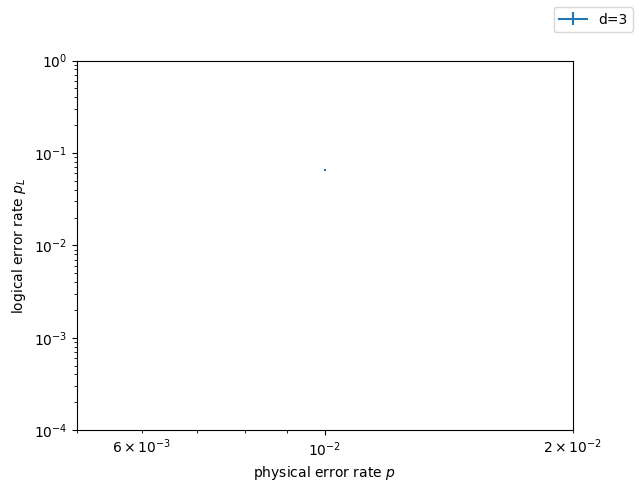

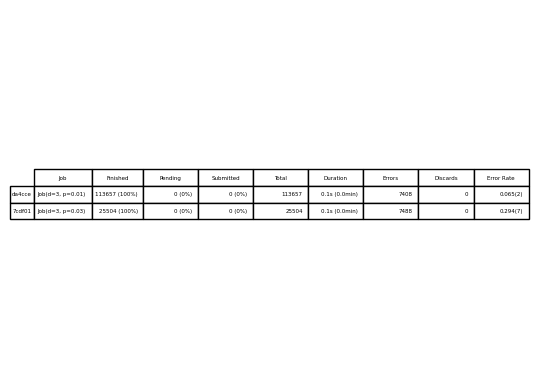

In [5]:
plotter = LogicalErrorRatePlotter(d_vec, p_vec)
progress_plotter = JobProgressPlotter()
def callback(executor: MonteCarloJobExecutor):
    plotter(executor)
    progress_plotter(executor)

# The rest of the notebook runs the evaluation

Start a cluster by intelligently choose Slurm or Local cluster.

In [12]:
try:
    from dask_jobqueue import SLURMCluster
    cluster = SLURMCluster(
        queue='scavenge',
        cores=1,
        memory="4 GB"
    )
    cluster.scale(slurm_maximum_jobs)
except:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
    cluster.scale(local_maximum_jobs)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63565 instead
  warnings.warn(
2025-01-24 10:09:03,946 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:63580' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'monitored_job-4aa955eace4b0aeebf9adcafac9a4570'} (stimulus_id='handle-worker-cleanup-1737731343.9467762')
2025-01-24 10:09:03,947 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:63579' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'monitored_job-f121060c7c66df9e556fab7f29ff75ae'} (stimulus_id='handle-worker-cleanup-1737731343.947871')


In [15]:
cluster

Dashboard: http://127.0.0.1:63565/status,Workers: 0
Total threads: 0,Total memory: 0 B
Status: closed,Using processes: True
Comm: tcp://127.0.0.1:63566,Workers: 0
Dashboard: http://127.0.0.1:63565/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [14]:
with Client(cluster) as client:
    try:
        executor = MonteCarloJobExecutor(
            client,
            monte_carlo_function,
            jobs,
            filename=json_filename,
        )
        executor.execute(submitter, loop_callback=callback)
    finally:
        print("shutting down the whole cluster; if this is not desired, comment it out")
        client.shutdown()